
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Selection of representative cases of multivariate wave conditions to simulate with SWAN
### Maximum Dissimilarity Algorithm (MDA)

inputs required: 
  * Historical waves
  * Emulator output - wave conditions

in this notebook:
  * Split sea and swell components
  * MDA selection of representative number of events


### Workflow:

<div>
<img src="../resources/nb02_01.png" width="400px">
</div>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database, hyswan_db
from teslakit.mda import MaxDiss_Simplified_NoThreshold, nearest_indexes

from teslakit.plotting.mda import Plot_MDA_Data



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# hyswan historical database
db_hist = hyswan_db(db.paths.site.HYSWAN.hist)

# GOW historical offshore waves data
WVS_hist = db.Load_WAVES_hist().to_dataframe()


# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 125            # subset size
ix_scalar = [0]           # tp
ix_directional = [1]      # dir


## Prepare Sea and Swells data

In [3]:
def split_sea_swells(WVS):
    '''
    splits WVS dataframe data into sea waves & swell waves dataframes
    
    requires WVS to contain variables with these names:
        'sea_Hs', 'sea_Tp', 'sea_Dir'
        'swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'
        'swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'
        ...
    
    '''
    
    # store n_sim if found in WVS dataset
    vns_extra = []
    if 'n_sim' in list(WVS.columns):
        vns_extra.append('n_sim') 

    
    # Prepare SEA waves
    vns_sea = ['sea_Hs', 'sea_Tp', 'sea_Dir'] + vns_extra
    
    wvs_sea = WVS[vns_sea]
    wvs_sea.dropna(inplace=True)  # clean nans
    wvs_sea.rename(columns={"sea_Hs":"hs", "sea_Tp":"tp", "sea_Dir": "dir"}, inplace=True)  # rename columns
    wvs_sea = wvs_sea[wvs_sea["dir"]<=360]  # filter data
    
    # Prepare SWELL_1 waves
    vns_swell_1 = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'] + vns_extra

    wvs_swell_1 = WVS[vns_swell_1]
    wvs_swell_1.dropna(inplace=True)
    wvs_swell_1.rename(columns={"swell_1_Hs":"hs", "swell_1_Tp":"tp", "swell_1_Dir": "dir"}, inplace=True)
    wvs_swell_1 = wvs_swell_1[wvs_swell_1["dir"]<=360]  

    # Prepare SWELL_2 waves
    vns_swell_2 = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'] + vns_extra

    wvs_swell_2 = WVS[vns_swell_2]
    wvs_swell_2.dropna(inplace=True)
    wvs_swell_2.rename(columns={"swell_2_Hs":"hs", "swell_2_Tp":"tp", "swell_2_Dir": "dir"}, inplace=True)
    wvs_swell_2 = wvs_swell_2[wvs_swell_2["dir"]<=360]  


    # join swell data
    wvs_swell = pd.concat([wvs_swell_1, wvs_swell_2], ignore_index=True)
    
    return wvs_sea, wvs_swell


In [4]:
# --------------------------------------
# split historical waves data: SEA / SWELLs

wvs_sea_hist, wvs_swl_hist = split_sea_swells(WVS_hist)

db_hist.Save('sea_dataset', wvs_sea_hist)
db_hist.Save('swl_dataset', wvs_swl_hist)



## MaxDiss Classification


MaxDiss waves parameters: 61761 --> 125

   MDA centroids: 125/125



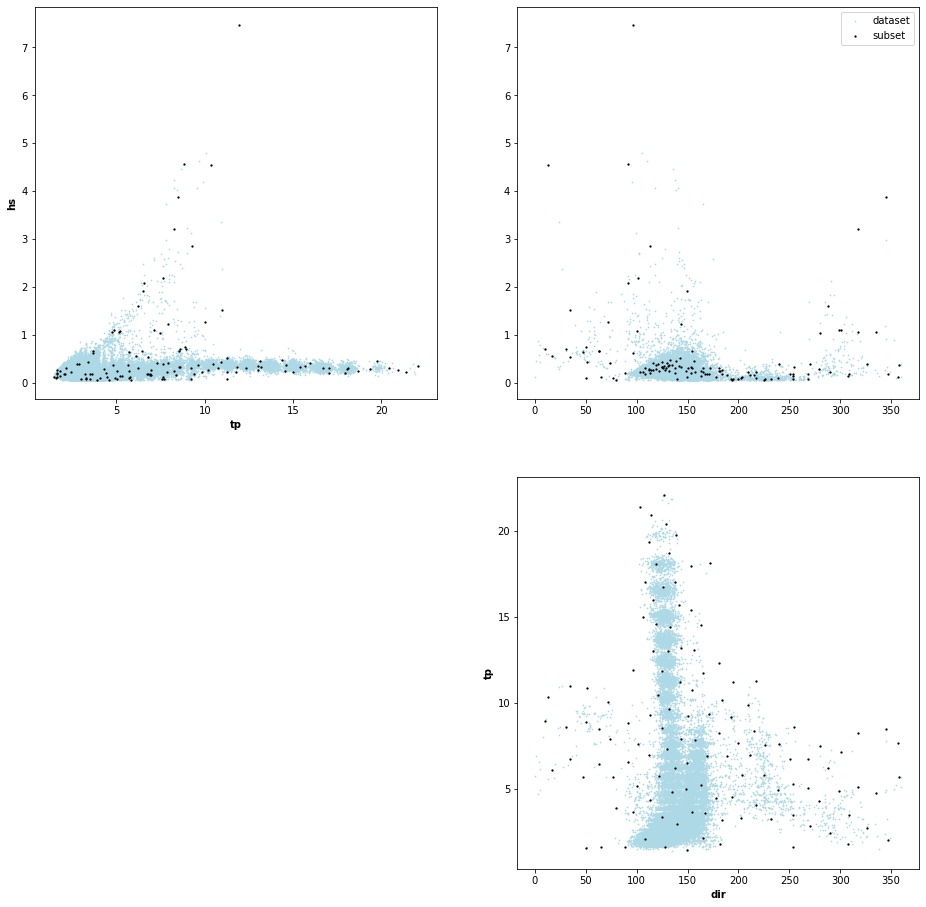

In [7]:
# --------------------------------------
# Sea
data = wvs_sea_hist[vns].values[:] 

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_sea_hist_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to sea subset
ix_n = nearest_indexes(wvs_sea_hist_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_sea_hist_subset['hs'] = wvs_sea_hist['hs'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_sea_hist, wvs_sea_hist_subset);

# Store MDA sea subset
db_hist.Save('sea_subset', wvs_sea_hist_subset)



MaxDiss waves parameters: 211534 --> 125

   MDA centroids: 125/125



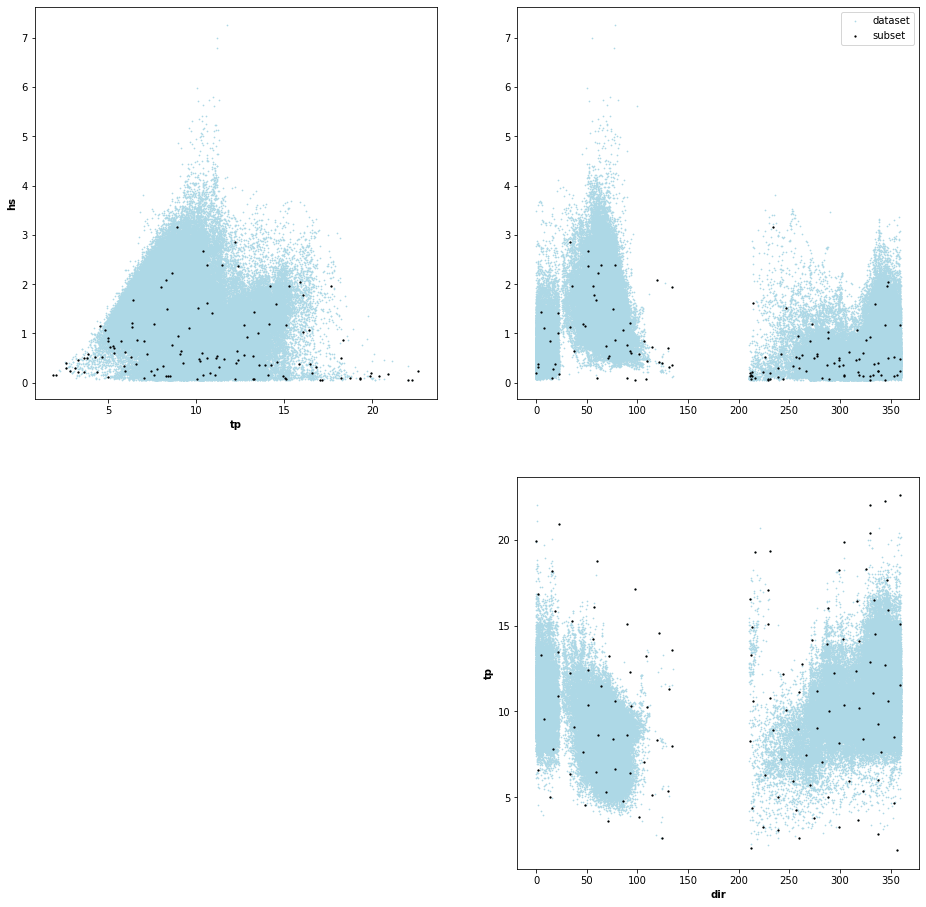

In [8]:
# --------------------------------------
# Swells
data = wvs_swl_hist[vns].values[:] 

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_swl_hist_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to sea subset
ix_n = nearest_indexes(wvs_swl_hist_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_swl_hist_subset['hs'] = wvs_swl_hist['hs'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_swl_hist, wvs_swl_hist_subset);

# Store MDA sea subset
db_hist.Save('swl_subset', wvs_swl_hist_subset)
